In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

/Users/danieltaber/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# LOAD
file = 'df_master_1992-2017_cleaned'
f = open(file,'rb') 
df = pickle.load(f) 
f.close()

In [3]:
df = df.dropna()
df = df.drop_duplicates(['imdb_name', 'imdb_year'])
len(df)

1900

In [4]:
df_bp = df[df.bp_nominee == 1.0]
len(df_bp)

154

In [5]:
df_noms = df[df.nominee == 1.0]
len(df_noms)

402

In [6]:
df.winner.value_counts()

0.0    1875
1.0      25
Name: winner, dtype: int64

# Exploratory data analysis

In [7]:
df.groupby('bp_nominee')['log_gross_new_norm', 'metacritic_norm', 'runtime', 'log_total_wins_norm'].mean()

,log_gross_new_norm,metacritic_norm,runtime,log_total_wins_norm
bp_nominee,,,,
0.0,-0.37484,-0.051709,109.540470,-0.385747
1.0,0.53396,0.625930,130.464853,0.883683


In [8]:
df_bp.groupby('winner')['log_gross_new_norm', 'metacritic_norm', 'runtime', 'log_total_wins_norm'].mean()

,log_gross_new_norm,metacritic_norm,runtime,log_total_wins_norm
winner,,,,
0.0,0.478816,0.516105,129.020057,0.774065
1.0,0.818502,1.192627,137.920000,1.449311


In [9]:
df.groupby('bp_nominee')['comedy', 'drama', 'mystery', 'family', 'sci-fi', 'musical',
                        'thriller', 'history', 'adventure', 'sport', 'biography', 'USA', 'UK', 'Winter'].mean()

,comedy,drama,mystery,family,sci-fi,musical,thriller,history,adventure,sport,biography,USA,UK,Winter
bp_nominee,,,,,,,,,,,,,,
0.0,0.270905,0.635739,0.082474,0.056128,0.044674,0.020046,0.169530,0.075601,0.092211,0.032646,0.112829,0.704467,0.166667,0.357388
1.0,0.175325,0.935065,0.064935,0.032468,0.051948,0.025974,0.194805,0.168831,0.142857,0.038961,0.246753,0.948052,0.259740,0.675325


In [10]:
df_bp.groupby('winner')['comedy', 'drama', 'mystery', 'family', 'sci-fi', 'musical',
                        'thriller', 'history', 'adventure', 'sport', 'biography', 'USA', 'UK',  'Spring'].mean()

,comedy,drama,mystery,family,sci-fi,musical,thriller,history,adventure,sport,biography,USA,UK,Spring
winner,,,,,,,,,,,,,,
0.0,0.170543,0.930233,0.077519,0.03876,0.062016,0.023256,0.193798,0.147287,0.147287,0.03876,0.248062,0.937984,0.263566,0.162791
1.0,0.200000,0.960000,0.000000,0.00000,0.000000,0.040000,0.200000,0.280000,0.120000,0.04000,0.240000,1.000000,0.240000,0.160000


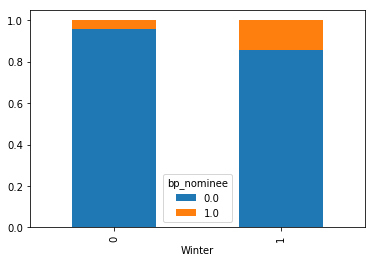

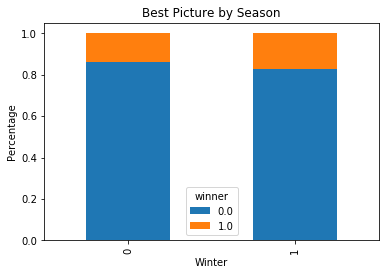

In [11]:
bp_genre = pd.crosstab(df.Winter, df.bp_nominee)
winner_genre = pd.crosstab(df_bp.Winter, df_bp.winner)

ax = bp_genre.div(bp_genre.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
ax = winner_genre.div(winner_genre.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Best Picture by Season')
plt.xlabel('Winter')
plt.ylabel('Percentage')

# Functions

In [12]:
def roc(classifier):
    y_score = classifier.predict_proba(xtest)[:,1]

    fpr, tpr, _ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot([0,1],[0,1]) # this is our baseline
    plt.plot(fpr, tpr) # this is our ROC curve
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    print('AUC: ', roc_auc)

In [49]:
# General classifer function + ROC
def train_score(classifier, x, y):
    
    # split data into to training and test sets
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain = np.ravel(ytrain)
    
    # fit a model
    clf = classifier.fit(xtrain, ytrain)
    
    # score the model (accuracy)
    train_acc = clf.score(xtrain, ytrain)
    test_acc = clf.score(xtest, ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    # create a confusion matrix
    y_true = ytest
    y_pred = clf.predict(xtest)

    conf = confusion_matrix(y_true, y_pred)
    print ('\n')
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
    # Plot ROC curve
    roc(classifier)

# MODELS

In [17]:
def category (data, outcome, categories): 
    global y
    global X
    y = data[outcome]
    X = data.loc[:, categories]

In [18]:
outcome = 'bp_nominee'
categories = ['log_gross_new_norm', 'log_total_wins_norm', 'metacritic_norm', 'runtime',
              'history', 'biography', 'comedy', 'drama', 'adventure',
             'Winter', 'USA', 'UK']
df_model = df

category (df_model, outcome, categories)

### Logistic regression

[[348   2]
 [ 16  14]]
AUC:  0.950476190476


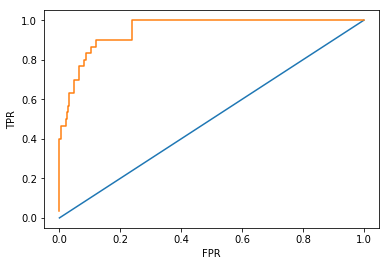

In [44]:
mm = MinMaxScaler()
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
xtrain = mm.fit_transform(xtrain)
xtest = mm.transform(xtest)
    
model_lr = LogisticRegression()
model_lr.fit(xtrain, ytrain)

y_pred = model_lr.predict(xtest)
print(confusion_matrix(ytest, y_pred))
roc(model_lr)

### Naive Bayes

[[347   3]
 [ 24   6]]
AUC:  0.831380952381


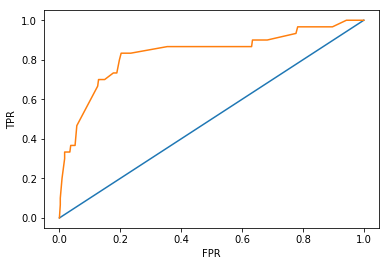

In [45]:
mm = MinMaxScaler()
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
xtrain = mm.fit_transform(xtrain)
xtest = mm.transform(xtest)

model_Bayes = naive_bayes.BernoulliNB()
model_Bayes.fit(xtrain, ytrain)

y_pred = model_Bayes.predict(xtest)
print(confusion_matrix(ytest, y_pred))
roc(model_Bayes)

### KNN

In [53]:
mm = MinMaxScaler()
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
xtrain = mm.fit_transform(xtrain)
xtest = mm.transform(xtest)

In [54]:
k_scores = []

for k in range(1, 20):

    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xtrain, ytrain, cv=5, scoring='recall')
    
    k_scores.append((k, scores.mean()))
    
k_scores = pd.DataFrame(k_scores, columns=['k', 'recall']).set_index('k')
k_scores[k_scores.recall==max(k_scores.recall)]

,recall
k,
1,0.451667


[[336  14]
 [ 17  13]]
AUC:  0.696666666667


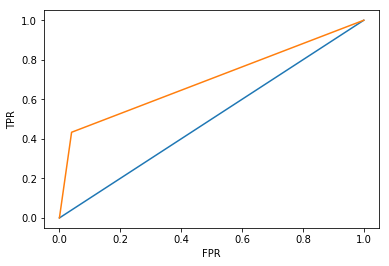

In [55]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(xtrain, ytrain)

y_pred = model_knn.predict(xtest)
print(confusion_matrix(ytest, y_pred))
roc(model_knn)

### SVM

In [56]:
mm = MinMaxScaler()
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)

xtrain_sc = mm.fit_transform(xtrain)
xtest_sc = mm.transform(xtest)

param_grid = {'C': [1.0, 10., 100.],
              'degree':[2,3,4],
              'kernel':['rbf'],
              'gamma':[3,4]}

svm = GridSearchCV(SVC(), param_grid=param_grid)
svm.fit(xtrain_sc, ytrain)
y_pred = svm.predict(xtest_sc)
print(confusion_matrix(ytest, y_pred))
print(accuracy_score(ytest, y_pred))

[[345   5]
 [ 23   7]]
0.926315789474


### Random forests

{'split0_test_score': array([ 0.4516129 ,  0.48387097,  0.5483871 ]), 'split1_test_score': array([ 0.48387097,  0.5483871 ,  0.51612903]), 'split2_test_score': array([ 0.4516129 ,  0.48387097,  0.51612903]), 'split3_test_score': array([ 0.5483871 ,  0.64516129,  0.58064516]), 'split4_test_score': array([ 0.33333333,  0.36666667,  0.36666667]), 'mean_test_score': array([ 0.45382569,  0.50565308,  0.50568704]), 'std_test_score': array([ 0.06976329,  0.09111015,  0.07340393]), 'rank_test_score': array([3, 2, 1], dtype=int32), 'split0_train_score': array([ 0.92682927,  0.96747967,  0.99186992]), 'split1_train_score': array([ 0.92682927,  0.99186992,  0.97560976]), 'split2_train_score': array([ 0.93495935,  0.98373984,  1.        ]), 'split3_train_score': array([ 0.94308943,  0.98373984,  0.97560976]), 'split4_train_score': array([ 0.93548387,  0.97580645,  0.99193548]), 'mean_train_score': array([ 0.93343824,  0.98052714,  0.98700498]), 'std_train_score': array([ 0.00611557,  0.00826829,  

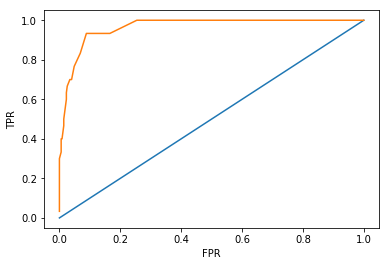

In [40]:
param_grid = {'n_estimators': [10, 20, 30], 'n_jobs': [-1]}
model_rf = GridSearchCV(RandomForestClassifier(), 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring='recall')
model_rf.fit(X,y)
print(model_rf.cv_results_)
train_score(model_rf, X, y)

### Gradient boosting

{'split0_test_score': array([ 0.41935484,  0.5483871 ,  0.61290323]), 'split1_test_score': array([ 0.38709677,  0.5483871 ,  0.64516129]), 'split2_test_score': array([ 0.38709677,  0.48387097,  0.48387097]), 'split3_test_score': array([ 0.19354839,  0.58064516,  0.64516129]), 'split4_test_score': array([ 0.23333333,  0.36666667,  0.36666667]), 'mean_test_score': array([ 0.32418393,  0.50568704,  0.55088229]), 'std_test_score': array([ 0.09197298,  0.07618642,  0.10951748]), 'rank_test_score': array([3, 2, 1], dtype=int32), 'split0_train_score': array([ 0.48780488,  0.63414634,  0.72357724]), 'split1_train_score': array([ 0.49593496,  0.59349593,  0.68292683]), 'split2_train_score': array([ 0.50406504,  0.69918699,  0.75609756]), 'split3_train_score': array([ 0.37398374,  0.6504065 ,  0.68292683]), 'split4_train_score': array([ 0.53225806,  0.63709677,  0.70967742]), 'mean_train_score': array([ 0.47880934,  0.64286651,  0.71104117]), 'std_train_score': array([ 0.05451097,  0.03398715,  

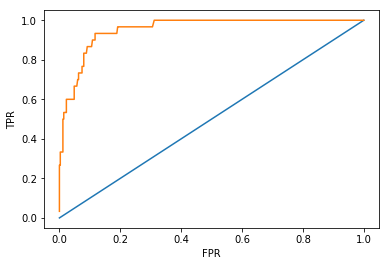

In [41]:
param_grid = {'n_estimators': [10, 20, 30]}
model_gbt = GridSearchCV(GradientBoostingClassifier(), 
                         param_grid=param_grid, 
                         cv=5, 
                         scoring='recall')
model_gbt.fit(X,y)
print(model_gbt.cv_results_)
train_score(model_gbt, X, y)

### AdaBoost

{'split0_test_score': array([ 0.74193548,  0.64516129,  0.70967742]), 'split1_test_score': array([ 0.70967742,  0.70967742,  0.70967742]), 'split2_test_score': array([ 0.51612903,  0.5483871 ,  0.5483871 ]), 'split3_test_score': array([ 0.61290323,  0.67741935,  0.67741935]), 'split4_test_score': array([ 0.46666667,  0.56666667,  0.6       ]), 'mean_test_score': array([ 0.60960724,  0.62950368,  0.64908998]), 'std_test_score': array([ 0.10648771,  0.06243003,  0.06434041]), 'rank_test_score': array([3, 2, 1], dtype=int32), 'split0_train_score': array([ 0.66666667,  0.68292683,  0.70731707]), 'split1_train_score': array([ 0.62601626,  0.67479675,  0.69105691]), 'split2_train_score': array([ 0.71544715,  0.74796748,  0.75609756]), 'split3_train_score': array([ 0.59349593,  0.70731707,  0.75609756]), 'split4_train_score': array([ 0.62096774,  0.68548387,  0.68548387]), 'mean_train_score': array([ 0.64451875,  0.6996984 ,  0.7192106 ]), 'std_train_score': array([ 0.0424775 ,  0.02642491,  

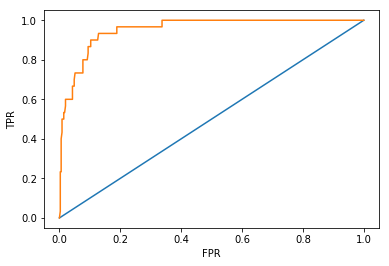

In [42]:
param_grid = {'n_estimators': [10, 20, 30]}
model_ada = GridSearchCV(AdaBoostClassifier(), 
                         param_grid=param_grid, 
                         cv=5, 
                         scoring='recall')
model_ada.fit(X,y)
print(model_ada.cv_results_)
train_score(model_ada, X, y)

AdaBoost model is the only one that isn't severely overfitting.

# Apply model to the full dataset

[[1712   34]
 [  48  106]]
Precision:              0.76
Recall:                 0.69


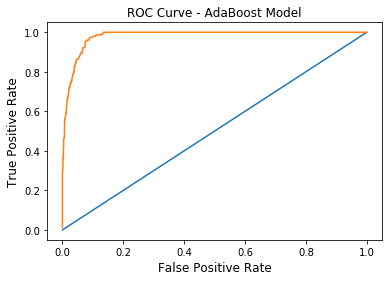

In [58]:
param_grid = {'n_estimators': [10, 20]}

model = GridSearchCV(AdaBoostClassifier(), 
                     param_grid=param_grid, 
                     cv=5, 
                     scoring='recall')
model.fit(X, y)

df_model['y_pred'] = model.predict(X)
df_model['y_pred_prob'] = model.predict_proba(X)[:,1]

conf = confusion_matrix(df_model[outcome], df_model['y_pred'])
print (conf)
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))

fpr, tpr, _ = roc_curve(y, df_model['y_pred_prob'] )
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot([0,1],[0,1]) # this is our baseline
plt.plot(fpr, tpr) # this is our ROC curve
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('ROC Curve - AdaBoost Model')
plt.show()

In [59]:
# Calculate the max probability by year to flag the 'winner'
pred_winners = df_model.loc[df_model.groupby('oscar_year')['y_pred_prob'].idxmax(),['imdb_name']]
pred_winners['pred_winner'] = 1.0
results = pd.merge(df_model, pred_winners, on='imdb_name', how='outer')
results['pred_winner'].fillna(0, inplace = True)

In [60]:
confusion_matrix(results['winner'], results['pred_winner'])

array([[1861,   14],
       [  14,   11]])

**Which movies were categorized correctly and incorrectly?**

In [61]:
results.loc[(results['winner'] == 1.0) & (results['pred_winner'] == 1.0)]

,imdb_name,imdb_year,log_gross_new_norm,drama,comedy,action,crime,romance,sport,biography,...,Winter,Summer,Spring,nominee,bp_nominee,oscar_name,oscar_year,y_pred,y_pred_prob,pred_winner
0,Unforgiven,1992,0.858717,1,0,0,0,0,0,0,...,0,1,0,1.0,1.0,unforgiven,1993,1.0,0.546718,1.0
52,Schindler's List,1993,0.527786,1,0,0,0,0,0,1,...,0,0,1,1.0,1.0,schindler's list,1994,1.0,0.546718,1.0
249,The English Patient,1996,0.675751,1,0,0,0,1,0,0,...,1,0,0,1.0,1.0,the english patient,1997,1.0,0.573377,1.0
424,Shakespeare in Love,1998,0.853134,1,1,0,0,1,0,0,...,1,0,0,1.0,1.0,shakespeare in love,1999,1.0,0.550755,1.0
519,American Beauty,1999,1.035309,1,0,0,0,1,0,0,...,1,0,0,1.0,1.0,american beauty,2000,1.0,0.541465,1.0
1039,The Departed,2006,1.023450,1,0,0,1,0,0,0,...,1,0,0,1.0,1.0,the departed,2007,1.0,0.564185,1.0
1108,No Country for Old Men,2007,0.674096,1,0,0,1,0,0,0,...,1,0,0,1.0,1.0,no country for old men,2008,1.0,0.541465,1.0
1189,Slumdog Millionaire,2008,0.852973,1,0,0,0,0,0,0,...,1,0,0,1.0,1.0,slumdog millionaire,2009,1.0,0.550755,1.0
1343,The King's Speech,2010,0.880265,1,0,0,0,0,0,1,...,1,0,0,1.0,1.0,the king's speech,2011,1.0,0.550755,1.0
1739,Spotlight,2015,0.241506,1,0,0,1,0,0,0,...,1,0,0,1.0,1.0,spotlight,2016,1.0,0.564185,1.0


In [62]:
results.loc[(results['winner'] == 0.0) & (results['pred_winner'] == 1.0)]

,imdb_name,imdb_year,log_gross_new_norm,drama,comedy,action,crime,romance,sport,biography,...,Winter,Summer,Spring,nominee,bp_nominee,oscar_name,oscar_year,y_pred,y_pred_prob,pred_winner
109,Pulp Fiction,1994,0.655720,1,0,0,1,0,0,0,...,1,0,0,1.0,1.0,pulp fiction,1995,1.0,0.564185,1.0
169,Sense and Sensibility,1995,0.085500,1,0,0,0,1,0,0,...,1,0,0,1.0,1.0,sense and sensibility,1996,1.0,0.550684,1.0
333,As Good as It Gets,1997,0.800518,1,1,0,0,1,0,0,...,1,0,0,1.0,1.0,as good as it gets,1998,1.0,0.549601,1.0
604,Traffic,2000,1.145964,1,0,0,1,0,0,0,...,1,0,0,1.0,1.0,traffic,2001,1.0,0.564185,1.0
680,The Lord of the Rings: The Fellowship of the Ring,2001,1.673625,1,0,0,0,0,0,0,...,1,0,0,1.0,1.0,the lord of the rings: the fellowship of the ring,2002,1.0,0.552025,1.0
749,Gangs of New York,2002,0.748612,1,0,0,1,0,0,0,...,1,0,0,1.0,1.0,gangs of new york,2003,1.0,0.536846,1.0
824,Mystic River,2003,0.635439,1,0,0,1,0,0,0,...,1,0,0,1.0,1.0,mystic river,2004,1.0,0.578321,1.0
898,Sideways,2004,0.370273,1,1,0,0,1,0,0,...,1,0,0,1.0,1.0,sideways,2005,1.0,0.887201,1.0
964,Brokeback Mountain,2005,0.628003,1,0,0,0,1,0,0,...,1,0,0,1.0,1.0,brokeback mountain,2006,1.0,0.564185,1.0
1266,Avatar,2009,2.034891,0,0,1,0,0,0,0,...,1,0,0,1.0,1.0,avatar,2010,1.0,0.531437,1.0


In [63]:
results.loc[(results['winner'] == 1.0) & (results['pred_winner'] == 0.0)]

,imdb_name,imdb_year,log_gross_new_norm,drama,comedy,action,crime,romance,sport,biography,...,Winter,Summer,Spring,nominee,bp_nominee,oscar_name,oscar_year,y_pred,y_pred_prob,pred_winner
107,Forrest Gump,1994,1.670313,1,1,0,0,1,0,0,...,0,1,0,1.0,1.0,forrest gump,1995,1.0,0.534473,0.0
166,Braveheart,1995,0.629701,1,0,0,0,0,0,1,...,0,0,1,1.0,1.0,braveheart,1996,1.0,0.532034,0.0
332,Titanic,1997,2.140691,1,0,0,0,1,0,0,...,1,0,0,1.0,1.0,titanic,1998,1.0,0.537368,0.0
600,Gladiator,2000,1.510074,1,0,1,0,0,0,0,...,0,0,1,1.0,1.0,gladiator,2001,1.0,0.516264,0.0
677,A Beautiful Mind,2001,1.131587,1,0,0,0,0,0,1,...,1,0,0,1.0,1.0,a beautiful mind,2002,1.0,0.504927,0.0
748,Chicago,2002,1.433880,0,1,0,1,0,0,0,...,1,0,0,1.0,1.0,chicago,2003,0.0,0.499128,0.0
821,The Lord of the Rings: The Return of the King,2003,1.803347,1,0,0,0,0,0,0,...,1,0,0,1.0,1.0,the lord of the rings: the return of the king,2004,1.0,0.552025,0.0
894,Million Dollar Baby,2004,0.600016,1,0,0,0,0,1,0,...,1,0,0,1.0,1.0,million dollar baby,2005,1.0,0.564185,0.0
963,Crash,2004,0.206835,1,0,0,1,0,0,0,...,0,0,1,1.0,1.0,crash,2006,0.0,0.496246,0.0
1265,The Hurt Locker,2008,-0.233494,1,0,0,0,0,0,0,...,0,1,0,1.0,1.0,the hurt locker,2010,1.0,0.523784,0.0


In [64]:
i = results.loc[(results['winner'] == 0.0) & (results['pred_winner'] == 1.0)].y_pred_prob.idxmax()

print("The biggest Best Picture snub in the last 25 years:")
print('\n')
print('\t' + results['imdb_name'][i])

The biggest Best Picture snub in the last 25 years:


	Sideways


**Export final results**

In [ ]:
# Assign the maximum predicted to everyone and calculate difference
results['y_pred_max'] = results.groupby('oscar_year')['y_pred_prob'].transform(max)
results['y_pred_diff'] = results['y_pred_prob'] - results['y_pred_max']
results.to_csv('final results.csv')

In [ ]:
# Create a subset of movies that were either predicted to win or actually did win
results_red = results.loc[(results['winner'] == 1.0) | (results['pred_winner'] == 1.0)]
results_red['y_pred_snub'] = abs(results_red.groupby('oscar_year')['y_pred_diff'].transform(min))
results_red.loc[results_red['pred_winner'] == 1.0, 'graph'] = results_red['y_pred_snub']
results_red.loc[results_red['winner'] == 1.0, 'graph'] = results_red['y_pred_diff']
results_red.to_csv('Tableau.csv')